In [1]:
import argparse
import subprocess
import os
import json
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep
import concurrent.futures
from matplotlib.patches import Patch

def load_data(input_dir):

    def stats_type_from_file_name(file_name):
        return file_name.split("_")[-1].split(".")[0]
    records = []
    for f in os.listdir(input_dir):
        if f.endswith(".json"):
            with open(os.path.join(input_dir, f)) as json_f:
                records.extend(json.load(json_f)[1:])
    df = pd.DataFrame(records)
    df['time_per_column'] = df['metadata_end_to_end_load_time_nanos'] / df['column_cnt']
    df['stats'] = df.apply(lambda x: stats_type_from_file_name(x['file_name']), axis=1)
    return df

In [14]:
input_dir =  "../target/wide_table_bench/"

df_new = load_data(input_dir + "new") 
df_old = load_data(input_dir + "old")

df_old['reduced_alloc'] = 'Baseline' 
df_new['reduced_alloc'] = 'Reduced allocation' 
df = pd.concat([df_new, df_old])

df['size_per_column'] = df['metadata_len'] / df['column_cnt']
df['bytes_per_ms'] = df['metadata_len'] / (df['metadata_end_to_end_load_time_nanos'] / 1_000_000)

def stats_order(x):
	if x['stats'] == 'none':
		return 1
	if x['stats'] == 'chunk':
		return 2
	if x['stats'] == 'page':
		return 3
df['order'] = df.apply(stats_order, axis=1)
df.sort_values(by='order', inplace=True)

In [15]:
time_per_column = df.groupby('stats')[['time_per_column', 'stats']].describe()['time_per_column']
time_per_column.sort_values(by='mean', ascending=True, inplace=True)

size_per_column = df.groupby('stats')[['size_per_column', 'stats']].describe()['size_per_column']
size_per_column.sort_values(by='mean', ascending=True, inplace=True)

In [23]:
df.groupby('stats')[['time_per_column', 'reduced_alloc']].describe()

time_per_column                                                   \
                count         mean         std         min         25%   
stats                                                                    
chunk            72.0  7337.705742  929.501943  5722.32800  6654.60225   
none             72.0  5432.199686  872.232826  4161.56500  4845.69975   
page             72.0  7798.131423  943.565305  6277.13442  7064.89475   

                                             
              50%          75%          max  
stats                                        
chunk  7137.46500  8014.795125   9869.64480  
none   5230.69085  5850.692725   7278.57164  
page   7470.27800  8481.408275  10484.21900

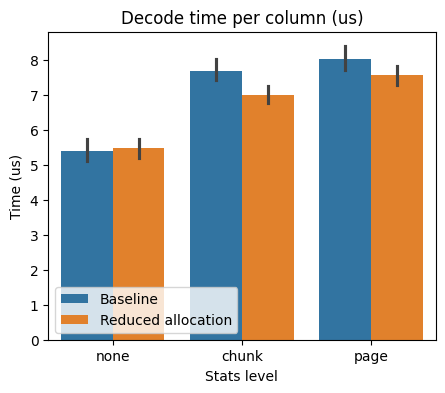

In [19]:
hue_order = ['Baseline', 'Reduced allocation']

fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
sns.barplot(x='stats', y='time_per_column', data=df, hue='reduced_alloc', hue_order=hue_order, ax=ax1)
ax1.set_xlabel('Stats level')
ax1.set_ylabel('Time (us)')
ax1.set_title('Decode time per column (us)')
ax1.legend(title='')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}'.format(x/1e3)))

fig.savefig('allocation.png', dpi=300)
